Load dataset

In [ ]:
pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error


In [ ]:
df = pd.read_csv("/content/Ecommerce_Sales_Prediction_Dataset.csv")

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              1000 non-null   object 
 1   Product_Category  1000 non-null   object 
 2   Price             1000 non-null   float64
 3   Discount          1000 non-null   float64
 4   Customer_Segment  1000 non-null   object 
 5   Marketing_Spend   1000 non-null   float64
 6   Units_Sold        1000 non-null   int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 54.8+ KB
None


Drop missing values

In [ ]:
df = df.dropna()

In [ ]:
print(df.describe(include='all'))

              Date Product_Category        Price     Discount  \
count         1000             1000  1000.000000  1000.000000   
unique        1000                5          NaN          NaN   
top     26/09/2025      Electronics          NaN          NaN   
freq             1              210          NaN          NaN   
mean           NaN              NaN   505.241920    24.919750   
std            NaN              NaN   289.791248    14.439951   
min            NaN              NaN    14.590000     0.010000   
25%            NaN              NaN   243.342500    12.995000   
50%            NaN              NaN   509.310000    24.965000   
75%            NaN              NaN   747.592500    37.562500   
max            NaN              NaN   999.420000    49.920000   

       Customer_Segment  Marketing_Spend   Units_Sold  
count              1000      1000.000000  1000.000000  
unique                3              NaN          NaN  
top             Regular              NaN          N

 Frequency distribution

In [ ]:
print("Frequency Distribution:")
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    print(f"\n{col} Frequency (%):")
    print(df[col].value_counts(normalize=True) * 100)

Frequency Distribution:

Date Frequency (%):
Date
26/09/2025    0.1
01/01/2023    0.1
02/01/2023    0.1
03/01/2023    0.1
04/01/2023    0.1
             ... 
13/01/2023    0.1
12/01/2023    0.1
11/01/2023    0.1
10/01/2023    0.1
09/01/2023    0.1
Name: proportion, Length: 1000, dtype: float64

Product_Category Frequency (%):
Product_Category
Electronics    21.0
Sports         20.6
Toys           20.4
Home Decor     19.0
Fashion        19.0
Name: proportion, dtype: float64

Customer_Segment Frequency (%):
Customer_Segment
Regular       34.5
Occasional    33.9
Premium       31.6
Name: proportion, dtype: float64


Central Tendency

In [ ]:
print("Central Tendency:")
print("Mean:\n", df.mean(numeric_only=True))
print("Median:\n", df.median(numeric_only=True))
print("Mode:\n", df.mode(numeric_only=True).iloc[0])

Central Tendency:
Mean:
 Price               505.24192
Discount             24.91975
Marketing_Spend    4912.83024
Units_Sold           29.63100
dtype: float64
Median:
 Price               509.310
Discount             24.965
Marketing_Spend    4837.245
Units_Sold           30.000
dtype: float64
Mode:
 Price              113.07
Discount            23.20
Marketing_Spend    100.30
Units_Sold          31.00
Name: 0, dtype: float64


Dispersion Measures

In [ ]:
print("Dispersion Measures:")
print("Range:\n", df.max(numeric_only=True) - df.min(numeric_only=True))
print("Variance:\n", df.var(numeric_only=True))
print("Standard Deviation:\n", df.std(numeric_only=True))

Dispersion Measures:
Range:
 Price               984.83
Discount             49.91
Marketing_Spend    9895.32
Units_Sold           52.00
dtype: float64
Variance:
 Price              8.397897e+04
Discount           2.085122e+02
Marketing_Spend    8.069023e+06
Units_Sold         5.282366e+01
dtype: float64
Standard Deviation:
 Price               289.791248
Discount             14.439951
Marketing_Spend    2840.602656
Units_Sold            7.267989
dtype: float64


Position Measures (Percentiles)

In [ ]:
print("Percentiles (25th, 50th, 75th):")
print(df.quantile([0.25, 0.5, 0.75], numeric_only=True))

Percentiles (25th, 50th, 75th):
         Price  Discount  Marketing_Spend  Units_Sold
0.25  243.3425   12.9950         2413.020        24.0
0.50  509.3100   24.9650         4837.245        30.0
0.75  747.5925   37.5625         7319.675        34.0


Outlier Detection using IQR

In [ ]:
print("Outliers using IQR method:")
for col in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))]
    if not outliers.empty:
        print(f"\nOutliers in {col}:")
        print(outliers[[col]])

Outliers using IQR method:

Outliers in Units_Sold:
     Units_Sold
138          50
261           5
522          52
544          50
641          57


In [ ]:
contingency_table = pd.crosstab(df['Product_Category'], df['Customer_Segment'] , margins=True)
print("Contingency Table:\n", contingency_table)

Contingency Table:
 Customer_Segment  Occasional  Premium  Regular   All
Product_Category                                    
Electronics               66       62       82   210
Fashion                   67       60       63   190
Home Decor                69       59       62   190
Sports                    62       68       76   206
Toys                      75       67       62   204
All                      339      316      345  1000


bar plot(Units Sold by Product Category)

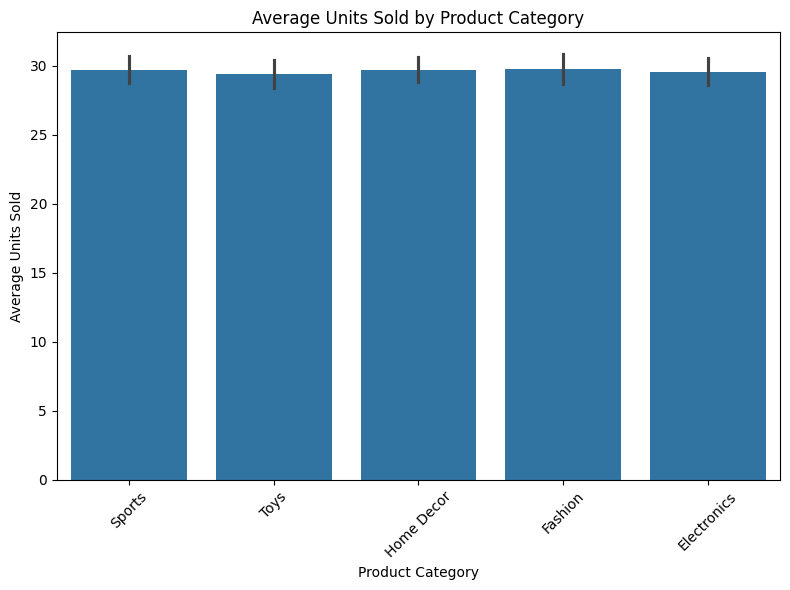

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Product_Category', y='Units_Sold', estimator=np.mean)
plt.title("Average Units Sold by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Average Units Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

box plot(Units Sold by Customer Segment)

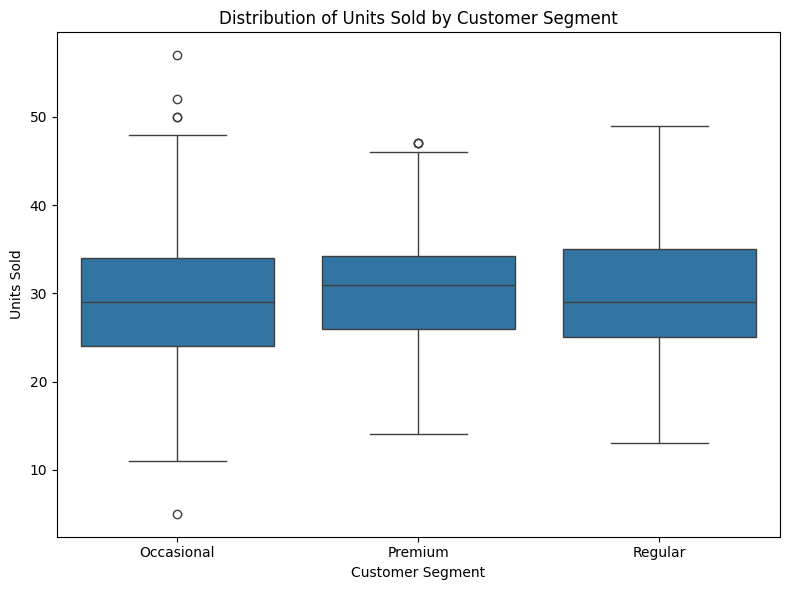

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Customer_Segment', y='Units_Sold')
plt.title("Distribution of Units Sold by Customer Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show()

scatter plot: Units Sold vs. Marketing Spend

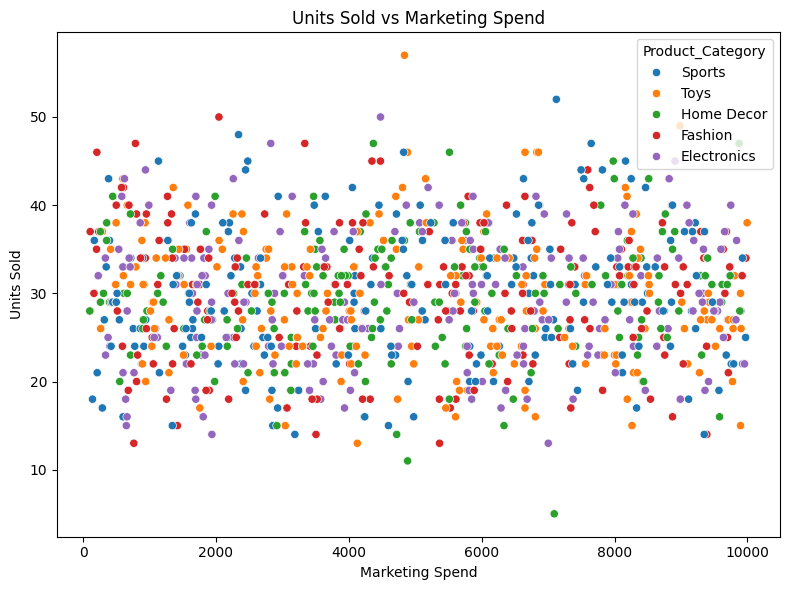

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Marketing_Spend', y='Units_Sold', hue='Product_Category')
plt.title("Units Sold vs Marketing Spend")
plt.xlabel("Marketing Spend")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show()

heatmap

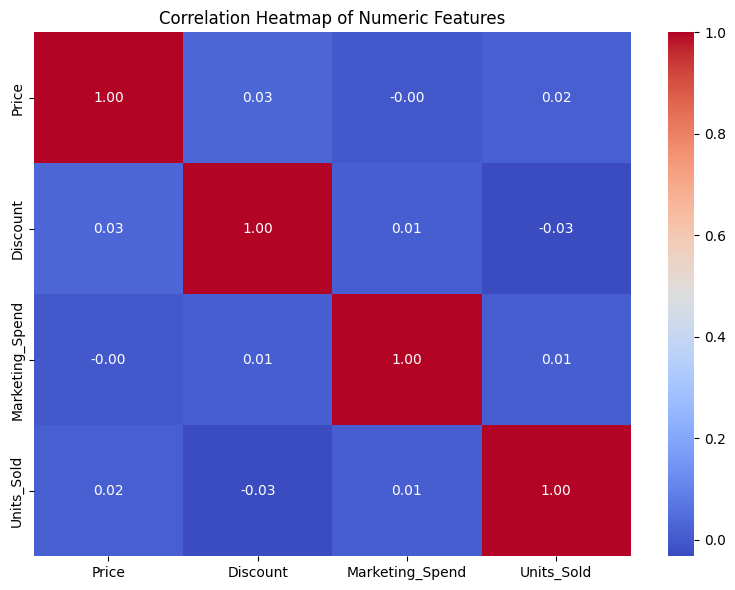

In [ ]:
plt.figure(figsize=(8, 6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

In [ ]:
X = df[['Price', 'Discount', 'Marketing_Spend']]
y = df['Units_Sold']

SelectKBest

In [ ]:
kbest = SelectKBest(score_func=f_regression, k=2)
X_kbest = kbest.fit_transform(X, y)
selected_kbest = X.columns[kbest.get_support()].tolist()

 Wrapper Method (Recursive Feature Elimination)


In [ ]:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=2)
X_rfe = rfe.fit_transform(X, y)
selected_rfe = X.columns[rfe.get_support()].tolist()

VarianceThreshold

In [ ]:
vt = VarianceThreshold(threshold=0.01)
X_vt = vt.fit_transform(X)
selected_vt = X.columns[vt.get_support()].tolist()

intersection of both

In [ ]:
selected_features = list(set(selected_kbest) & set(selected_rfe) & set(selected_vt))

X_final = df[selected_features]
y_final = df['Units_Sold']

  Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

Linear Regression

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

Decision Tree Regressor

In [ ]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)

Exponential Smoothing

In [ ]:
df_ts = df.sort_values('Date')
df_ts['Date'] = pd.to_datetime(df_ts['Date'], dayfirst=True)
df_ts.set_index('Date', inplace=True)
ets_model = ExponentialSmoothing(df_ts['Units_Sold'], trend='add', seasonal=None, initialization_method='estimated')
ets_fit = ets_model.fit()
ets_preds = ets_fit.forecast(steps=len(y_test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


LSTM

In [ ]:
scaler = MinMaxScaler()
scaled_units = scaler.fit_transform(df_ts[['Units_Sold']])

Prepare sequences

In [ ]:
sequence_length = 10
X_lstm, y_lstm = [], []
for i in range(sequence_length, len(scaled_units)):
    X_lstm.append(scaled_units[i-sequence_length:i, 0])
    y_lstm.append(scaled_units[i, 0])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

LSTM Model

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_lstm.shape[1], 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_lstm, y_lstm, epochs=10, batch_size=32, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Forecast next value

In [ ]:
lstm_input = scaled_units[-sequence_length:].reshape(1, sequence_length, 1)
lstm_forecast = scaler.inverse_transform(lstm_model.predict(lstm_input))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


Evaluation Function

In [ ]:
def evaluate(y_true, y_pred, name):
    return {
        "Model": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }

evaluation results

In [ ]:
results = [
    evaluate(y_test, lr_preds, "Linear Regression"),
    evaluate(y_test, dt_preds, "Decision Tree"),
    evaluate(y_test, ets_preds[:len(y_test)], "Exponential Smoothing"),
    {"Model": "LSTM", "MAE": "-", "MSE": "-", "RMSE": "-", "R²": "-", "Forecast Next": lstm_forecast}
]

In [ ]:
results_df = pd.DataFrame(results)
print("Model Evaluation Results:\n")
print(results_df)

Model Evaluation Results:

                   Model       MAE        MSE       RMSE        R2   R²  \
0      Linear Regression  5.914496  54.643512   7.392125 -0.010349  NaN   
1          Decision Tree     8.385    113.605  10.658565 -1.100538  NaN   
2  Exponential Smoothing  5.930773  55.069518   7.420884 -0.018226  NaN   
3                   LSTM         -          -          -       NaN    -   

   Forecast Next  
0            NaN  
1            NaN  
2            NaN  
3      29.331125  


Bar Chart - MAE

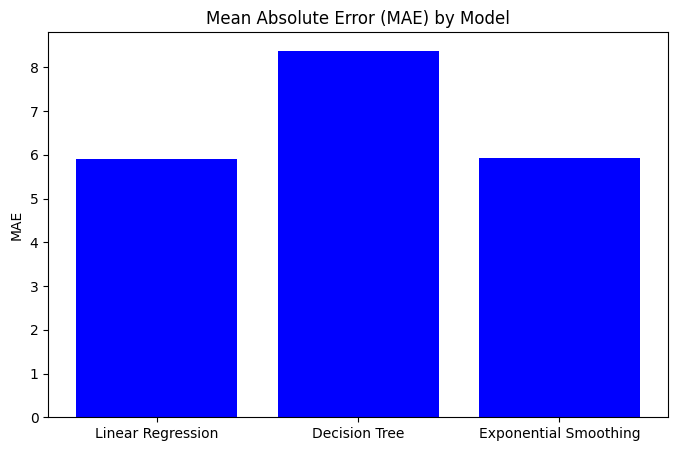

In [ ]:
mae_df = results_df[results_df["MAE"] != "-"]
plt.figure(figsize=(8, 5))
plt.bar(mae_df["Model"], mae_df["MAE"], color='blue')
plt.title("Mean Absolute Error (MAE) by Model")
plt.ylabel("MAE")
plt.show()

Bar Chart - R² Score

Text(0, 0.5, 'R2')

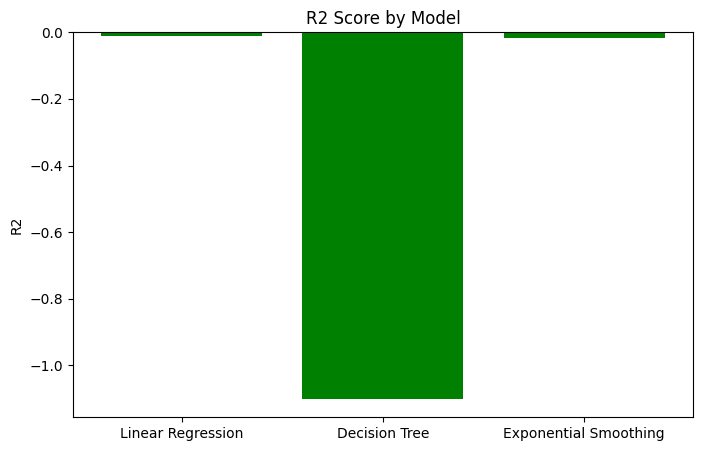

In [ ]:
r2_df = results_df[results_df["R2"] != "-"]
plt.figure(figsize=(8, 5))
plt.bar(r2_df["Model"], r2_df["R2"], color='green')
plt.title("R2 Score by Model")
plt.ylabel("R2")

In [ ]:
X = df[['Price', 'Discount', 'Marketing_Spend']].values
y = df['Units_Sold'].values

In [ ]:
def objective_linear(w):
    predictions = w[0] + w[1]*X[:, 0] + w[2]*X[:, 1] + w[3]*X[:, 2]
    return mean_squared_error(y, predictions)

bounds = [(-5, 0)] * 4
initial_guess = [-1, -1, -1, -1]

linear_result = minimize(objective_linear, initial_guess, bounds=bounds)
linear_weights = linear_result.x
linear_predictions = linear_weights[0] + linear_weights[1]*X[:, 0] + linear_weights[2]*X[:, 1] + linear_weights[3]*X[:, 2]
linear_mse = mean_squared_error(y, linear_predictions)

In [ ]:
pop_size = 30
n_gen = 10
gene_bounds = (-5, 0)
num_genes = 4
elite_count = 1
crossover_p = 0.8
mutate_p = 0.3

In [ ]:
def fitness(individual):
    preds = individual[0] + individual[1]*X[:, 0] + individual[2]*X[:, 1] + individual[3]*X[:, 2]
    return -mean_squared_error(y, preds)

pop = np.random.uniform(gene_bounds[0], gene_bounds[1], size=(pop_size, num_genes))
best_history = []

for gen in range(n_gen):
    fitness_vals = np.array([fitness(ind) for ind in pop])
    best_idx = np.argmax(fitness_vals)
    best_fit = fitness_vals[best_idx]
    best_ind = pop[best_idx]
    best_history.append((gen, -best_fit, best_ind.copy()))

    elites = pop[[best_idx]].copy()
    min_f = fitness_vals.min()
    weights = fitness_vals - min_f + 1e-6
    probs = weights / weights.sum()
    selected = pop[np.random.choice(range(pop_size), size=pop_size - elite_count, p=probs)]

    children = []
    for i in range(0, len(selected)-1, 2):
        if np.random.rand() < crossover_p:
            cp = np.random.randint(1, num_genes)
            a, b = selected[i].copy(), selected[i+1].copy()
            a[cp:], b[cp:] = b[cp:], a[cp:]
            children.append(a)
            children.append(b)
        else:
            children.append(selected[i])
            children.append(selected[i+1])

    if len(children) < pop_size - elite_count:
        children.append(selected[np.random.randint(len(selected))])

    for i in range(len(children)):
        for j in range(num_genes):
            if np.random.rand() < mutate_p:
                delta = np.random.uniform(-1, 1)
                children[i][j] = np.clip(children[i][j] + delta, gene_bounds[0], gene_bounds[1])

    pop = np.vstack([elites] + children[:pop_size - elite_count])

best_gen, best_fit, best_ind = max(best_history, key=lambda x: x[1])
final_prediction = best_ind[0] + best_ind[1]*X[:, 0] + best_ind[2]*X[:, 1] + best_ind[3]*X[:, 2]
final_mse = mean_squared_error(y, final_prediction)

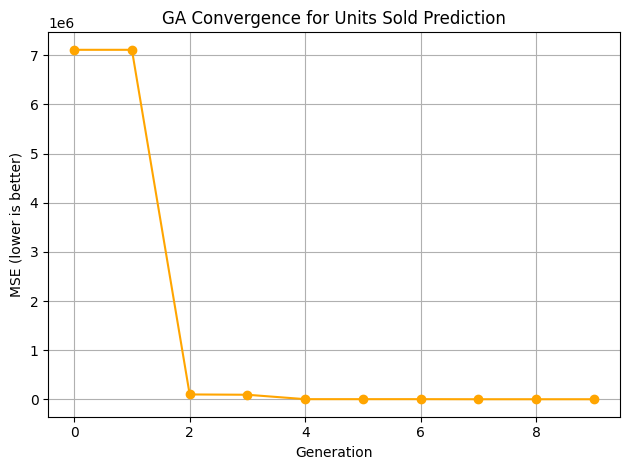

In [ ]:
plt.plot([gen for gen, _, _ in best_history], [mse for _, mse, _ in best_history], marker='o', color='orange')
plt.xlabel("Generation")
plt.ylabel("MSE (lower is better)")
plt.title("GA Convergence for Units Sold Prediction")
plt.grid(True)
plt.tight_layout()
plt.show()

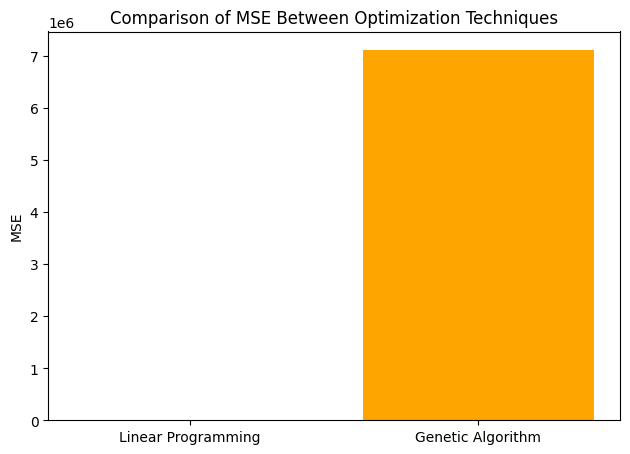

In [ ]:
methods = ['Linear Programming', 'Genetic Algorithm']
mses = [linear_mse, final_mse]
plt.bar(methods, mses, color=['blue', 'orange'])
plt.title("Comparison of MSE Between Optimization Techniques")
plt.ylabel("MSE")
plt.tight_layout()
plt.show()

In [ ]:
print("Linear Programming Weights:", linear_weights)
print("Linear Programming MSE:", linear_mse)
print("Genetic Algorithm Weights:", best_ind)
print("Genetic Algorithm MSE:", final_mse)

Linear Programming Weights: [0. 0. 0. 0.]
Linear Programming MSE: 930.767
Genetic Algorithm Weights: [-0.21960276 -0.46374188 -0.67054442 -0.4259111 ]
Genetic Algorithm MSE: 7112539.748353957
